In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.ensemble import IsolationForest

In [17]:
data = pd.read_csv('binance_6months.csv')

In [18]:
data.head(5)

,datetime,open,high,low,close,volume
0,2024-02-07 07:30:00,42961.10,42961.10,42953.93,42953.94,5.14845
1,2024-02-07 07:31:00,42953.93,42953.94,42953.93,42953.93,4.00253
2,2024-02-07 07:32:00,42953.94,42953.94,42951.10,42953.93,5.13712
3,2024-02-07 07:33:00,42953.93,42967.48,42953.93,42967.47,13.43767
4,2024-02-07 07:34:00,42967.47,42967.48,42967.47,42967.48,4.90092


### Data Preprocessing

In [19]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['return'] = data['close'].pct_change()
data['volatility'] = data['return'].rolling(window=10).std()

In [20]:
data.dropna(inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume', 'return', 'volatility']])

In [21]:
timesteps = 5
X = []
for i in range(timesteps, len(data_scaled)):
    X.append(data_scaled[i-timesteps:i])
X = np.array(X)

### Anomaly Detection Using LSTM Autoencoder

In [22]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(timesteps, X.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X.shape[2])))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 32)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             24832     
                                                                 
 time_distributed (TimeDistr  (None, 5, 7)             455       
 ibuted)                                                

In [24]:
history = model.fit(X, X, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
7290/7290 [==============================] - 42s 5ms/step - loss: 7.2227e-04 - val_loss: 0.0052
Epoch 2/10
7290/7290 [==============================] - 38s 5ms/step - loss: 8.7210e-04 - val_loss: 0.0055
Epoch 3/10
7290/7290 [==============================] - 38s 5ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 4/10
7290/7290 [==============================] - 39s 5ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 5/10
7290/7290 [==============================] - 35s 5ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 6/10
7290/7290 [==============================] - 35s 5ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 7/10
7290/7290 [==============================] - 35s 5ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 8/10
7290/7290 [==============================] - 35s 5ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 9/10
7290/7290 [==============================] - 35s 5ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 10/10
7290/7290 [==============================] - 35s 5ms/

##### Reconstruction Error Calculation and Anomaly Detection

In [25]:
X_pred = model.predict(X)

# mean squared error between the original and reconstructed data
mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))

8100/8100 [==============================] - 15s 2ms/step


In [26]:
# threshold for anomaly detection
threshold = np.percentile(mse, 95)

In [47]:
lstm_anomalies  = mse > threshold

In [49]:
total_records = X_pred.shape[0]
num_anomalies = np.sum(anomalies)
percentage_anomalies = (num_anomalies / total_records) * 100

print(f"Total number of records: {total_records}")
print(f"Number of anomalies detected: {num_anomalies}")
print(f"Perentage of anomalies detected: {percentage_anomalies:.2f}%")

Total number of records: 259186
Number of anomalies detected: 12960
Perentage of anomalies detected: 5.00%


##### reconstruction error and threshold

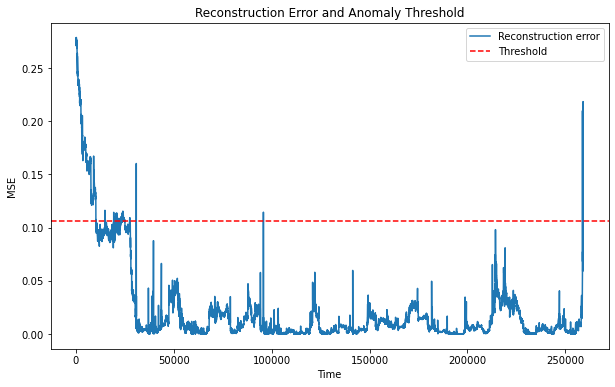

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(mse, label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error and Anomaly Threshold')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.legend()
plt.show()

##### close price trend over time

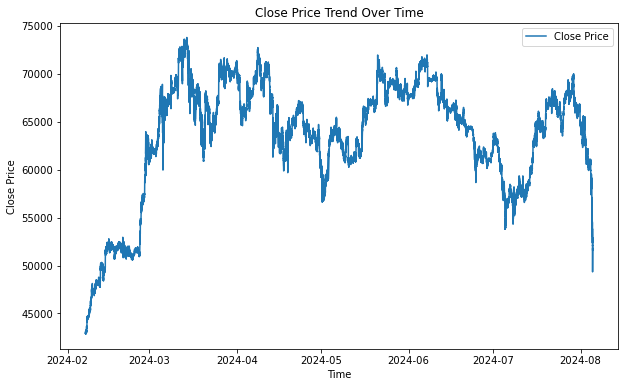

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['close'], label='Close Price')
plt.title('Close Price Trend Over Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

##### volume and volatility over time

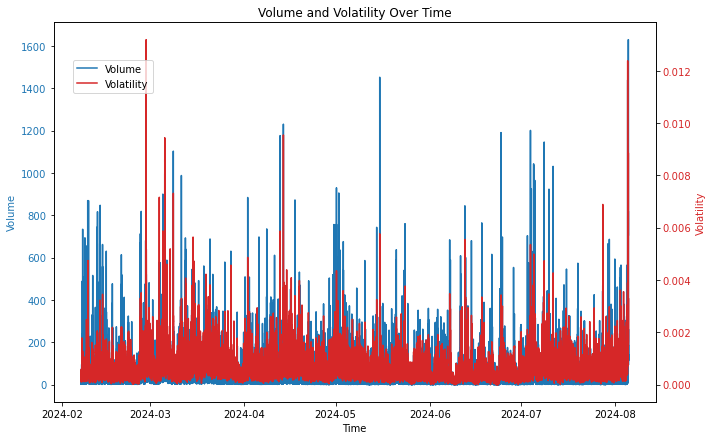

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Volume', color='tab:blue')
ax1.plot(data['datetime'], data['volume'], color='tab:blue', label='Volume')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volatility', color='tab:red')
ax2.plot(data['datetime'], data['volatility'], color='tab:red', label='Volatility')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Volume and Volatility Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

##### synthetic stress test data

In [35]:
data_stress_test = data.copy()

# High volatility condition
high_volatility_data = data.copy()
high_volatility_data['close'] = high_volatility_data['close'] * (1 + np.random.normal(0, 0.05, len(high_volatility_data)))

# Market crash condition
market_crash_data = data.copy()
market_crash_data['close'] = market_crash_data['close'] * 0.7  # Simulate a 30% market crash

# Combine all stress test data
stress_test_data = {
    'Normal': data,
    'High Volatility': high_volatility_data,
    'Market Crash': market_crash_data
}

In [1]:
def evaluate_model_on_stress_test(stress_data, model, scaler, timesteps):
    stress_data_scaled = scaler.transform(stress_data[['open', 'high', 'low', 'close', 'volume', 'return', 'volatility']])
    X_stress = []
    for i in range(timesteps, len(stress_data_scaled)):
        X_stress.append(stress_data_scaled[i-timesteps:i])
    X_stress = np.array(X_stress)
    
    # reconstructed data
    X_stress_pred = model.predict(X_stress)
    
    # mean squared error between the original and reconstructed data
    mse_stress = np.mean(np.power(X_stress - X_stress_pred, 2), axis=(1, 2))
    
    return mse_stress

8100/8100 [==============================] - 15s 2ms/step


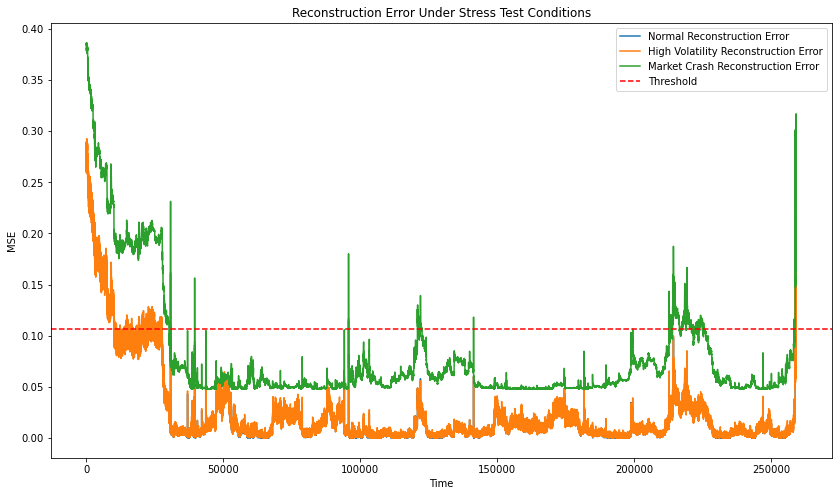

In [37]:
# Perform stress testing
stress_test_results = {}
for condition, stress_data in stress_test_data.items():
    mse_stress = evaluate_model_on_stress_test(stress_data, model, scaler, timesteps)
    stress_test_results[condition] = mse_stress

plt.figure(figsize=(14, 8))
for condition, mse_stress in stress_test_results.items():
    plt.plot(mse_stress, label=f'{condition} Reconstruction Error')
plt.axhline(y=np.percentile(mse, 95), color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Under Stress Test Conditions')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.legend()
plt.show()
